#### About
* Car segmentation via Fine-tuning of MaskRCNN in PyTorch

* Dataset Link- https://www.kaggle.com/datasets/intelecai/car-segmentation

* Classes Info
0 - background
1 - car
2 - wheel
3 - light
4 - windows


In [1]:
# importing libraries
import numpy as np
import torch
import pandas as pd
import torchvision
import os
import glob
import random
import torch.nn as nn
import torch.utils.data as data
import scipy.misc as S

from torchvision import datasets,models
from torchvision.transforms import functional as F
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict,deque
import datetime
import math
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
import cv2
from typing_extensions import Concatenate
from skimage.transform import resize
from collections import Counter

# bbox and mask predictors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor




In [2]:
device = torch.device("cuda")
torch.cuda.is_available()

True

In [3]:
dataset_path= "/kaggle/input/car-segmentation/car-segmentation"
#contains folders images and masks which in turn contain pair of png files

In [4]:
#defining a dataset class to load the data that inherits from torch.utils.data.Dataset class and implement __len__ and __getitem__ methods

class CarDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, index):
        #loading image and masks
        img_path = os.path.join(self.root, "images", self.images[index])
        mask_path = os.path.join(self.root, "masks", self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        part_ids = np.unique(mask)
        #Removing background
        part_ids = part_ids[1:] #0

        #splitting into binary masks
        masks = mask == part_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_parts = len(part_ids)
        boxes = []
        for i in range(num_parts):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = []
        for part_id in part_ids: 
          labels.append(part_id)
        labels= torch.tensor((labels), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_parts,), dtype=torch.int64)
        

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        
        if self.transforms is not None:
           img, target = self.transforms(image, target)

        return img, target

    def __len__(self):
        return len(self.images)    

## Fine Tuning Phase
Modifying the pretrained head of MaskRCNN with new. The MaskRCNN has object detector and mask_detector heads which need to be modified.

In [5]:
def SegmentationModel(num_classes):
    #loading instance seg pretrained model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replacing pretrained head with new
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

    #now doing the same for input features for mask
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer=512
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

In [9]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 348226, done.
remote: Counting objects: 100% (64300/64300), done.
remote: Compressing objects: 100% (1448/1448), done.
remote: Total 348226 (delta 63051), reused 63849 (delta 62800), pack-reused 283926
Receiving objects: 100% (348226/348226), 700.49 MiB | 33.93 MiB/s, done.
Resolving deltas: 100% (321108/321108), done.
/kaggle/working/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch'

In [11]:
!pip install pycocotools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93593 sha256=58cedf03b7dfb82b0c2853ea9f22fd8a080efdeb9552a72f2148da89994d81ec
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools


In [23]:
import torch
print(torch.__version__)

2.0.0


In [29]:
pip install torch==1.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 712.0 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [30]:
from torch import inf

In [32]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [34]:
def apply_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [35]:
train_dataset = CarDataset(dataset_path, apply_transform(train=True))
val_dataset = CarDataset(dataset_path, apply_transform(train=False))


In [36]:
train_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'boxes': tensor([[ 59.,  25., 831., 342.],
          [137., 213., 770., 345.],
          [ 74., 124., 822., 179.],
          [259.,  47., 792., 132.]]),
  'labels': tensor([1, 2, 3, 4]),
 

In [37]:
val_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'boxes': tensor([[ 59.,  25., 831., 342.],
          [137., 213., 770., 345.],
          [ 74., 124., 822., 179.],
          [259.,  47., 792., 132.]]),
  'labels': tensor([1, 2, 3, 4]),
 

In [42]:
pip install --upgrade torch

  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 2.0.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [46]:
import torch
torch.has_mps

False

In [45]:
from torch import mps

In [47]:
# splitting the dataset on train and val with constant seed
torch.manual_seed(42)

idxs = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, idxs[:-10])
val_dataset = torch.utils.data.Subset(train_dataset,idxs[-10:])


In [48]:
#creating data loader
train_data_loader = DataLoader(train_dataset,batch_size=2, shuffle=True,num_workers=4, collate_fn=utils.collate_fn)

val_data_loader = DataLoader(val_dataset,batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In [49]:
device = torch.device('cuda')
num_classes =5
model = SegmentationModel(num_classes)
model.to(device)
optimizer= torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 236MB/s]  


In [50]:
for epoch in range(10):
  train_one_epoch(model, optimizer, train_data_loader,device,epoch,print_freq=20)
  optimizer.step()
  evaluate(model,val_data_loader,device=device)

Epoch: [0]  [  0/101]  eta: 0:23:54  lr: 0.000011  loss: 3.7871 (3.7871)  loss_classifier: 1.9097 (1.9097)  loss_box_reg: 0.1668 (0.1668)  loss_mask: 1.3101 (1.3101)  loss_objectness: 0.2626 (0.2626)  loss_rpn_box_reg: 0.1379 (0.1379)  time: 14.2050  data: 0.5694  max mem: 3885
Epoch: [0]  [ 20/101]  eta: 0:01:57  lr: 0.000211  loss: 1.3637 (1.9941)  loss_classifier: 0.3302 (0.6578)  loss_box_reg: 0.2427 (0.2399)  loss_mask: 0.4420 (0.6968)  loss_objectness: 0.0404 (0.1595)  loss_rpn_box_reg: 0.2236 (0.2401)  time: 0.8111  data: 0.0237  max mem: 4636
Epoch: [0]  [ 40/101]  eta: 0:01:10  lr: 0.000411  loss: 0.7083 (1.3723)  loss_classifier: 0.1107 (0.3986)  loss_box_reg: 0.2061 (0.2293)  loss_mask: 0.1980 (0.4624)  loss_objectness: 0.0106 (0.0889)  loss_rpn_box_reg: 0.1375 (0.1931)  time: 0.8604  data: 0.0287  max mem: 4834
Epoch: [0]  [ 60/101]  eta: 0:00:43  lr: 0.000610  loss: 0.5106 (1.0985)  loss_classifier: 0.0660 (0.2930)  loss_box_reg: 0.1508 (0.2033)  loss_mask: 0.1603 (0.3662)

KeyboardInterrupt: 

In [54]:
torch.save(model, '/kaggle/working/mask-rcnn-car_seg.pt')

In [58]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'car','wheel','lights','window']
device = torch.device('cuda') 
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [59]:
def color_mask(mask):
    # defining 5 colors for segmentation
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,5)]
    coloured_mask = np.stack([r, g, b], axis=2) #stacking along channel axis
    return coloured_mask

def predict(img_path, confidence):
    
    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()

    img = convert_tensor(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def visualize_predictions(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

    masks, boxes, pred_cls = predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = color_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.6, 0)
      boxes[i][0] = [int(i) for i in boxes[i][0]]
      boxes[i][1] = [int(i) for i in boxes[i][1]]
      
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

libpng warning: iCCP: known incorrect sRGB profile


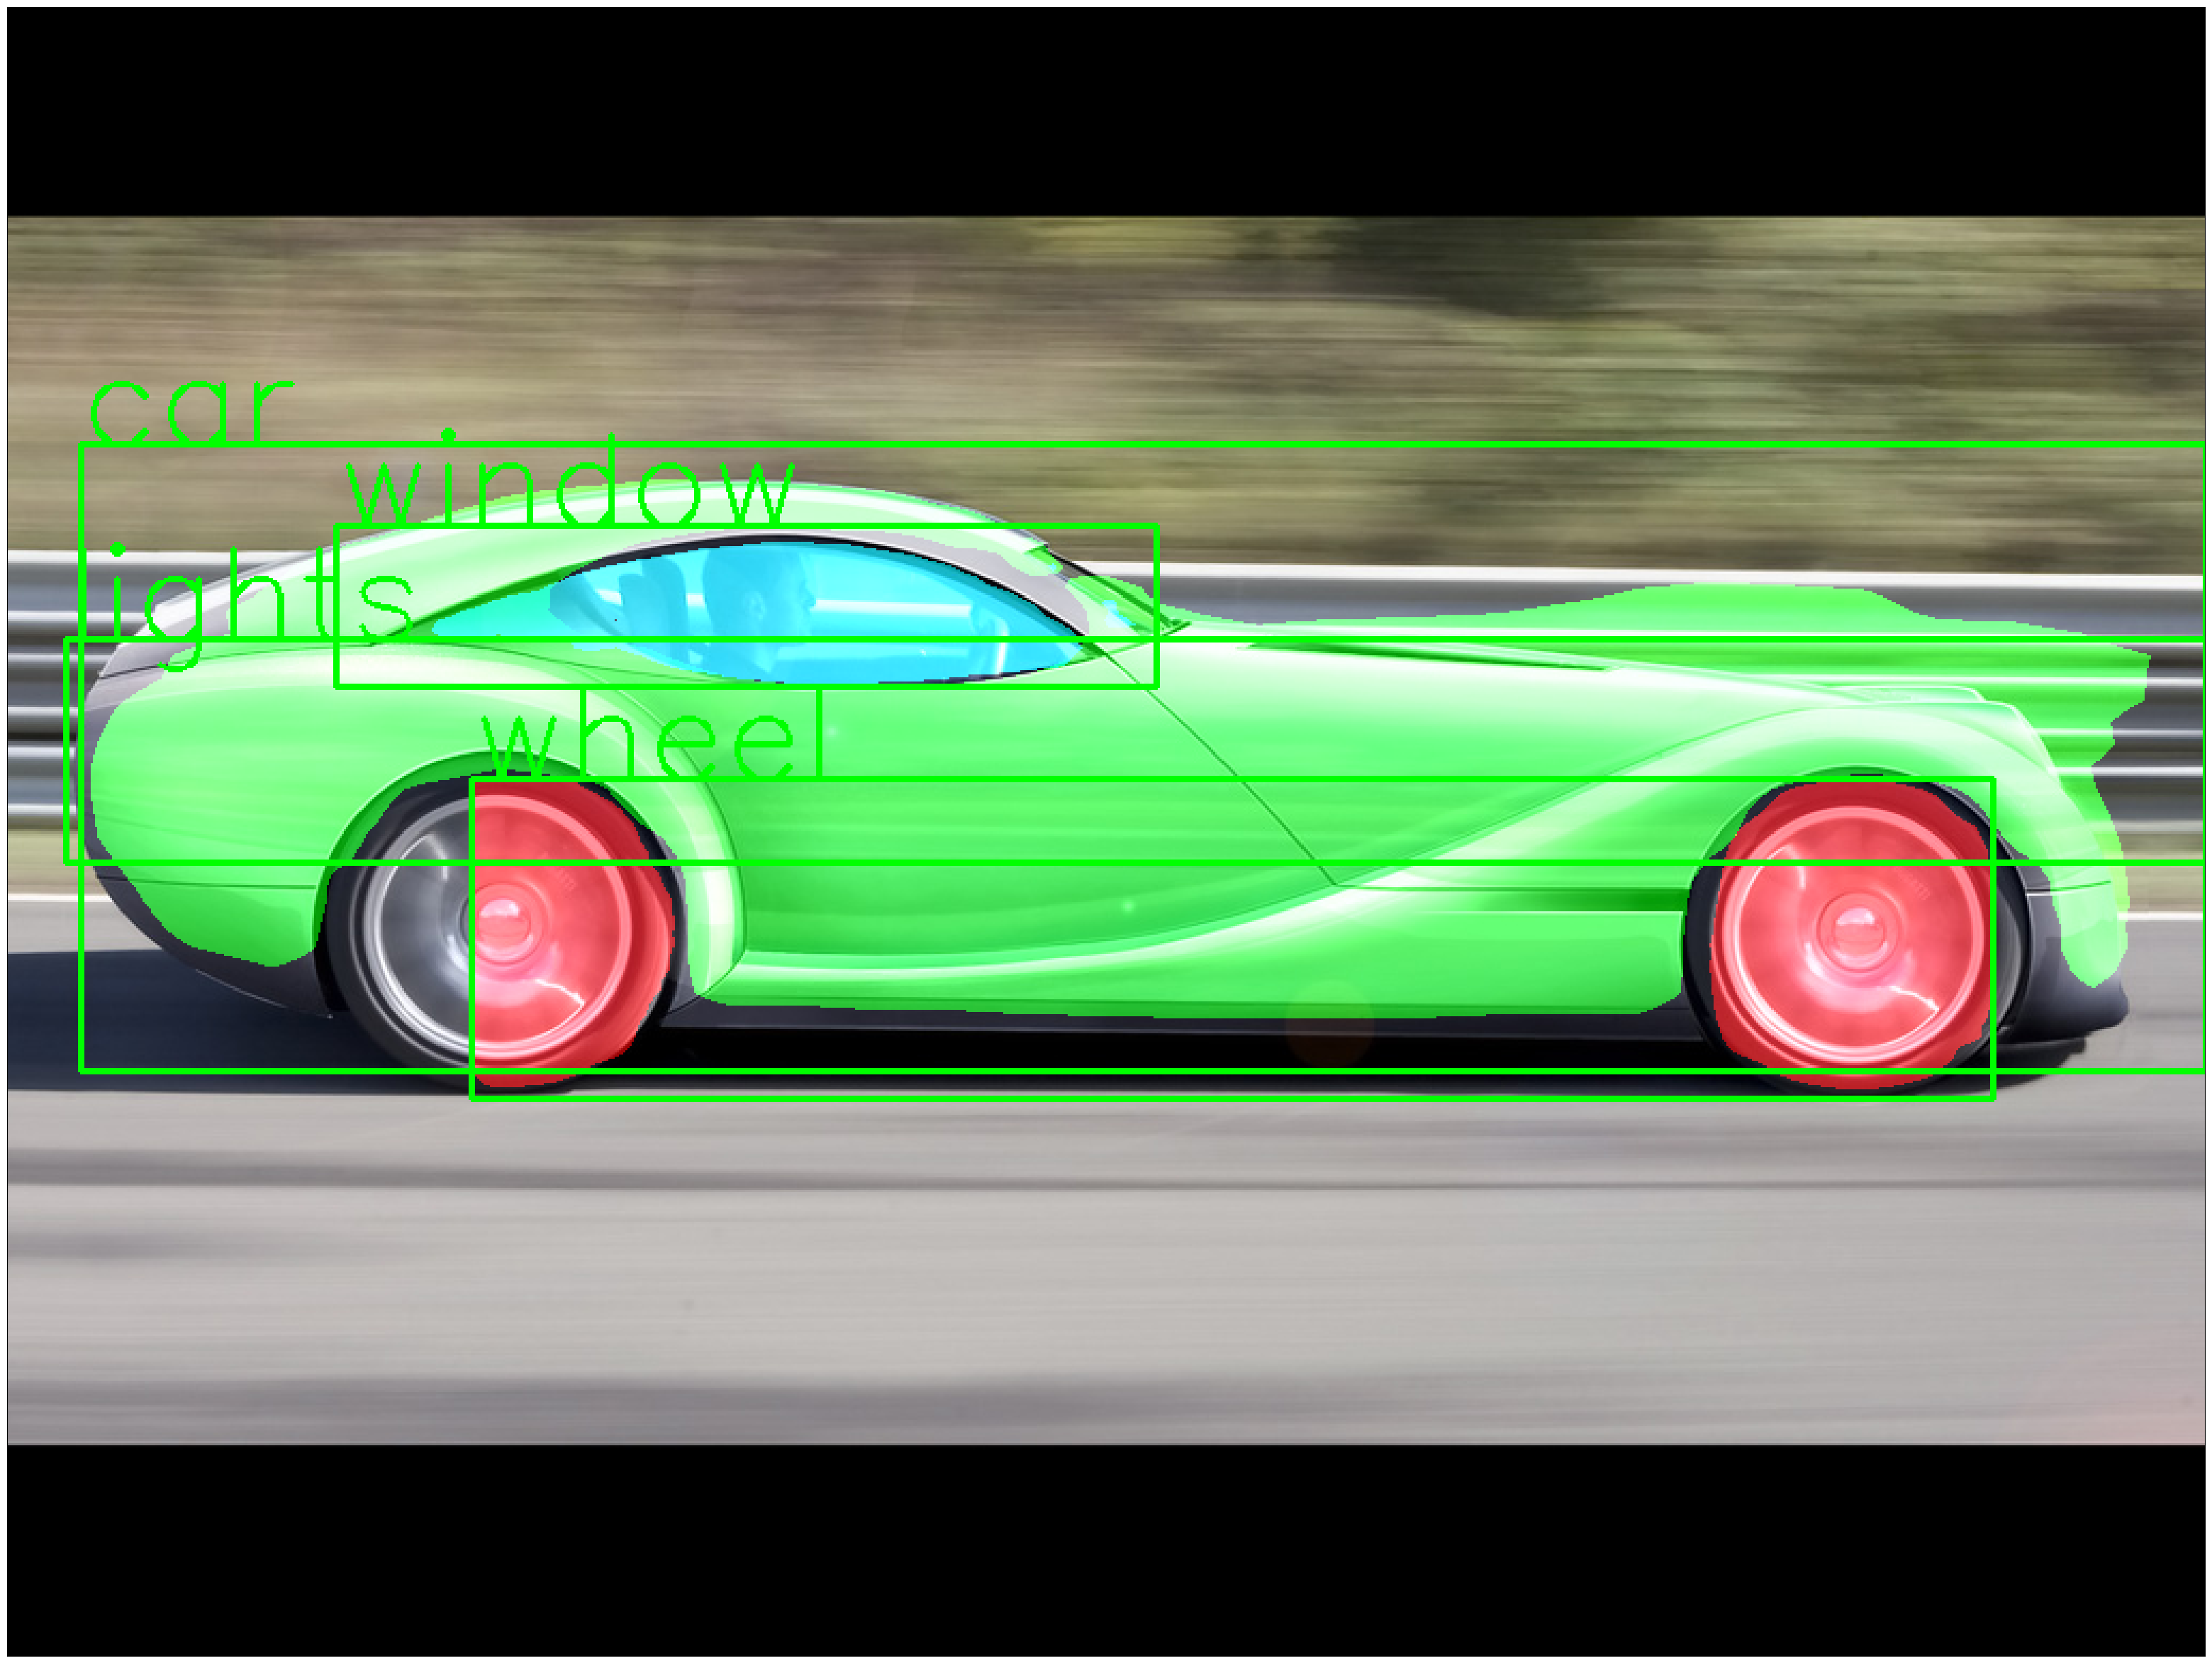

In [60]:
visualize_predictions('/kaggle/input/car-segmentation/car-segmentation/images/2008-Morgan-Life-Car-Side-Speed-1024x768.png', confidence=0.5)

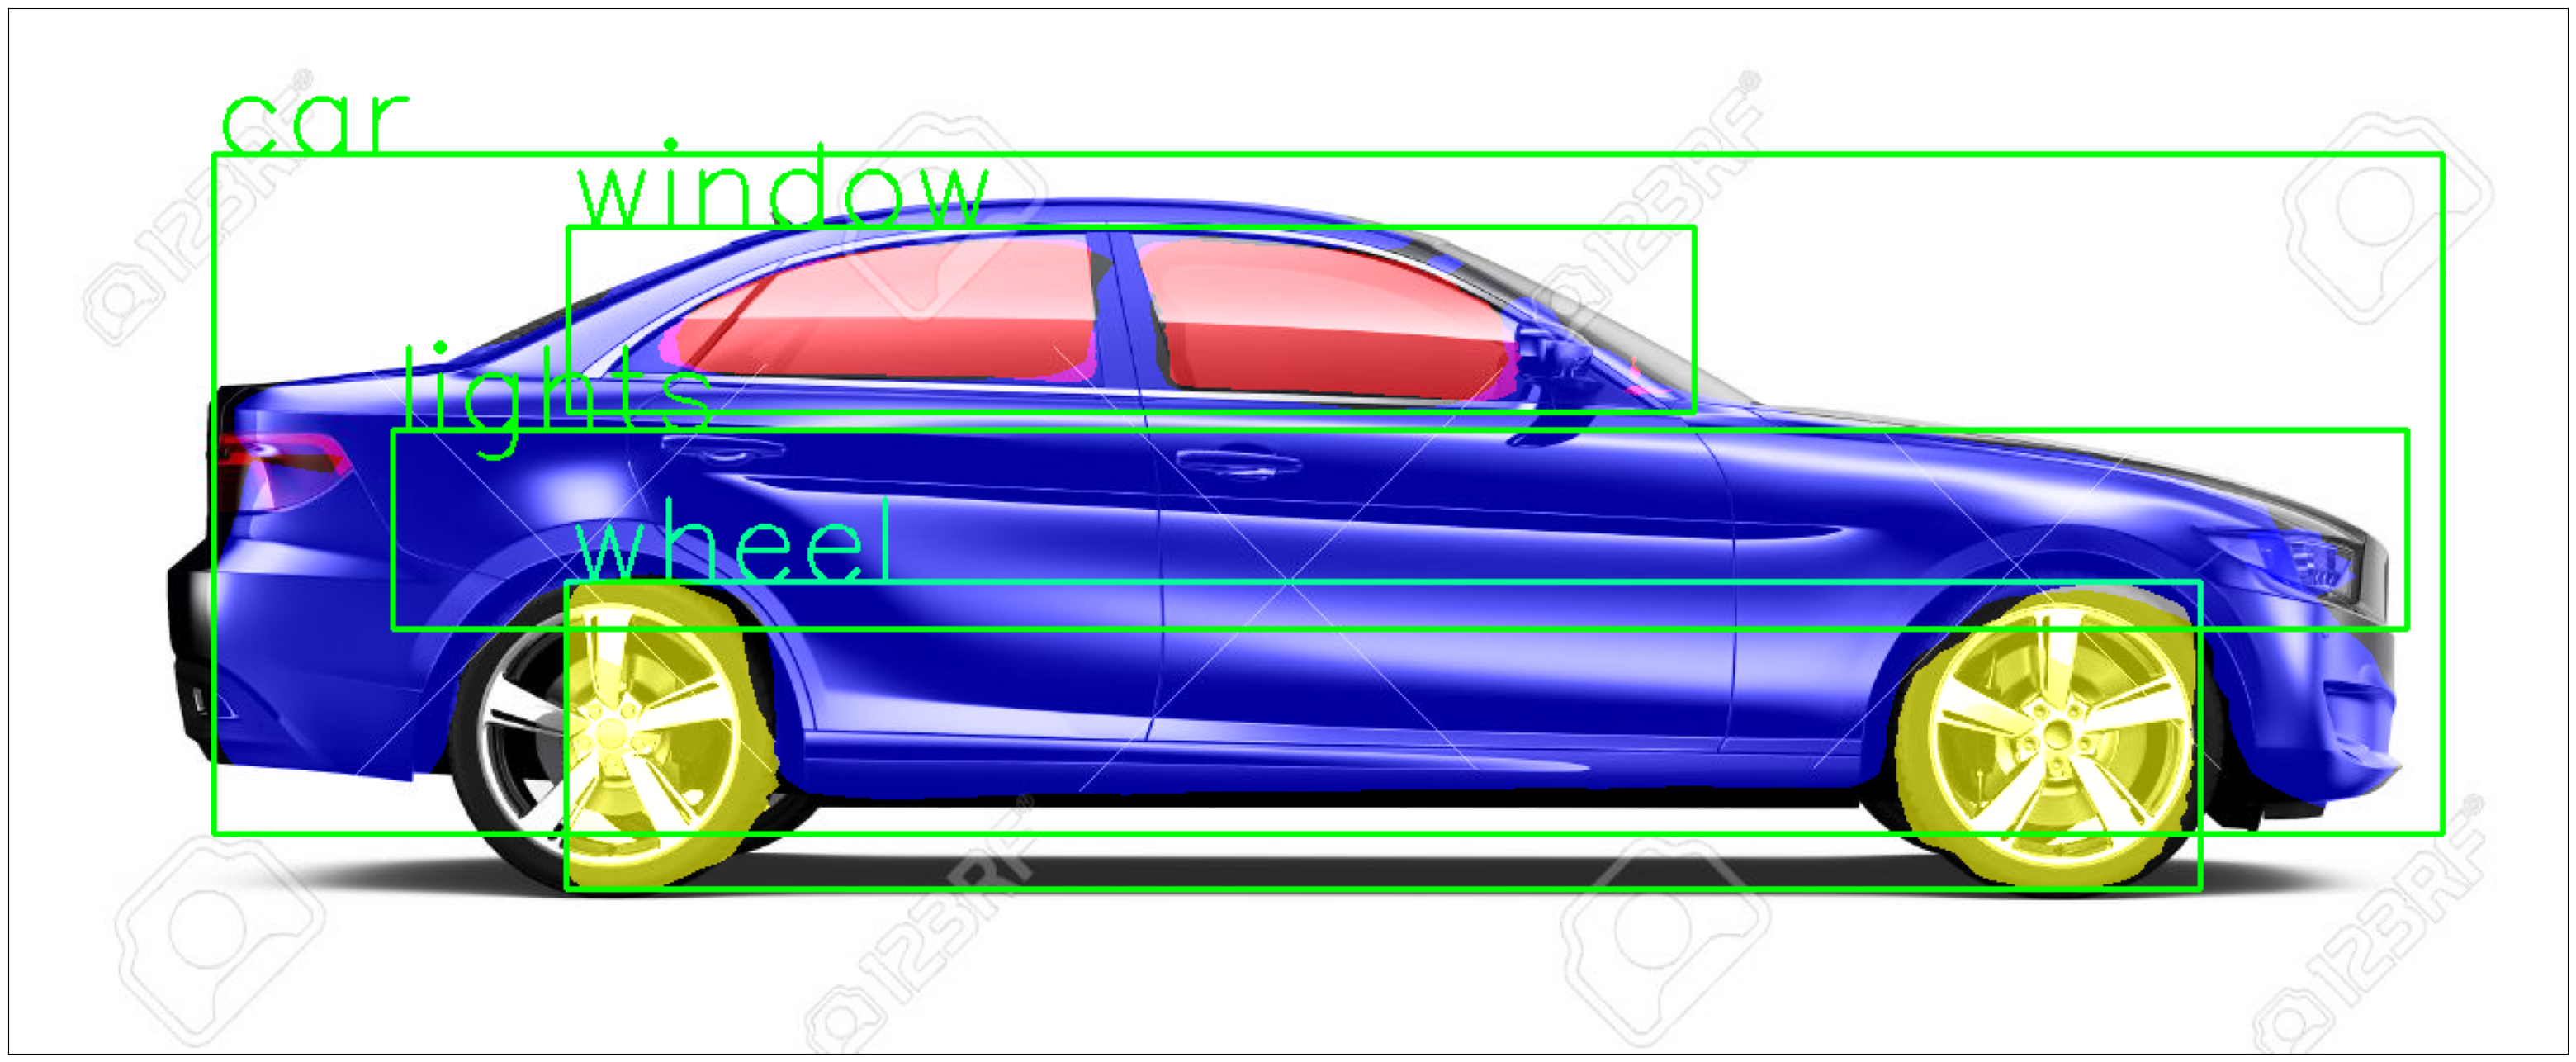

In [61]:
visualize_predictions('/kaggle/input/car-segmentation/car-segmentation/images/39839516-black-sedan-car-side-view.png', confidence=0.7)

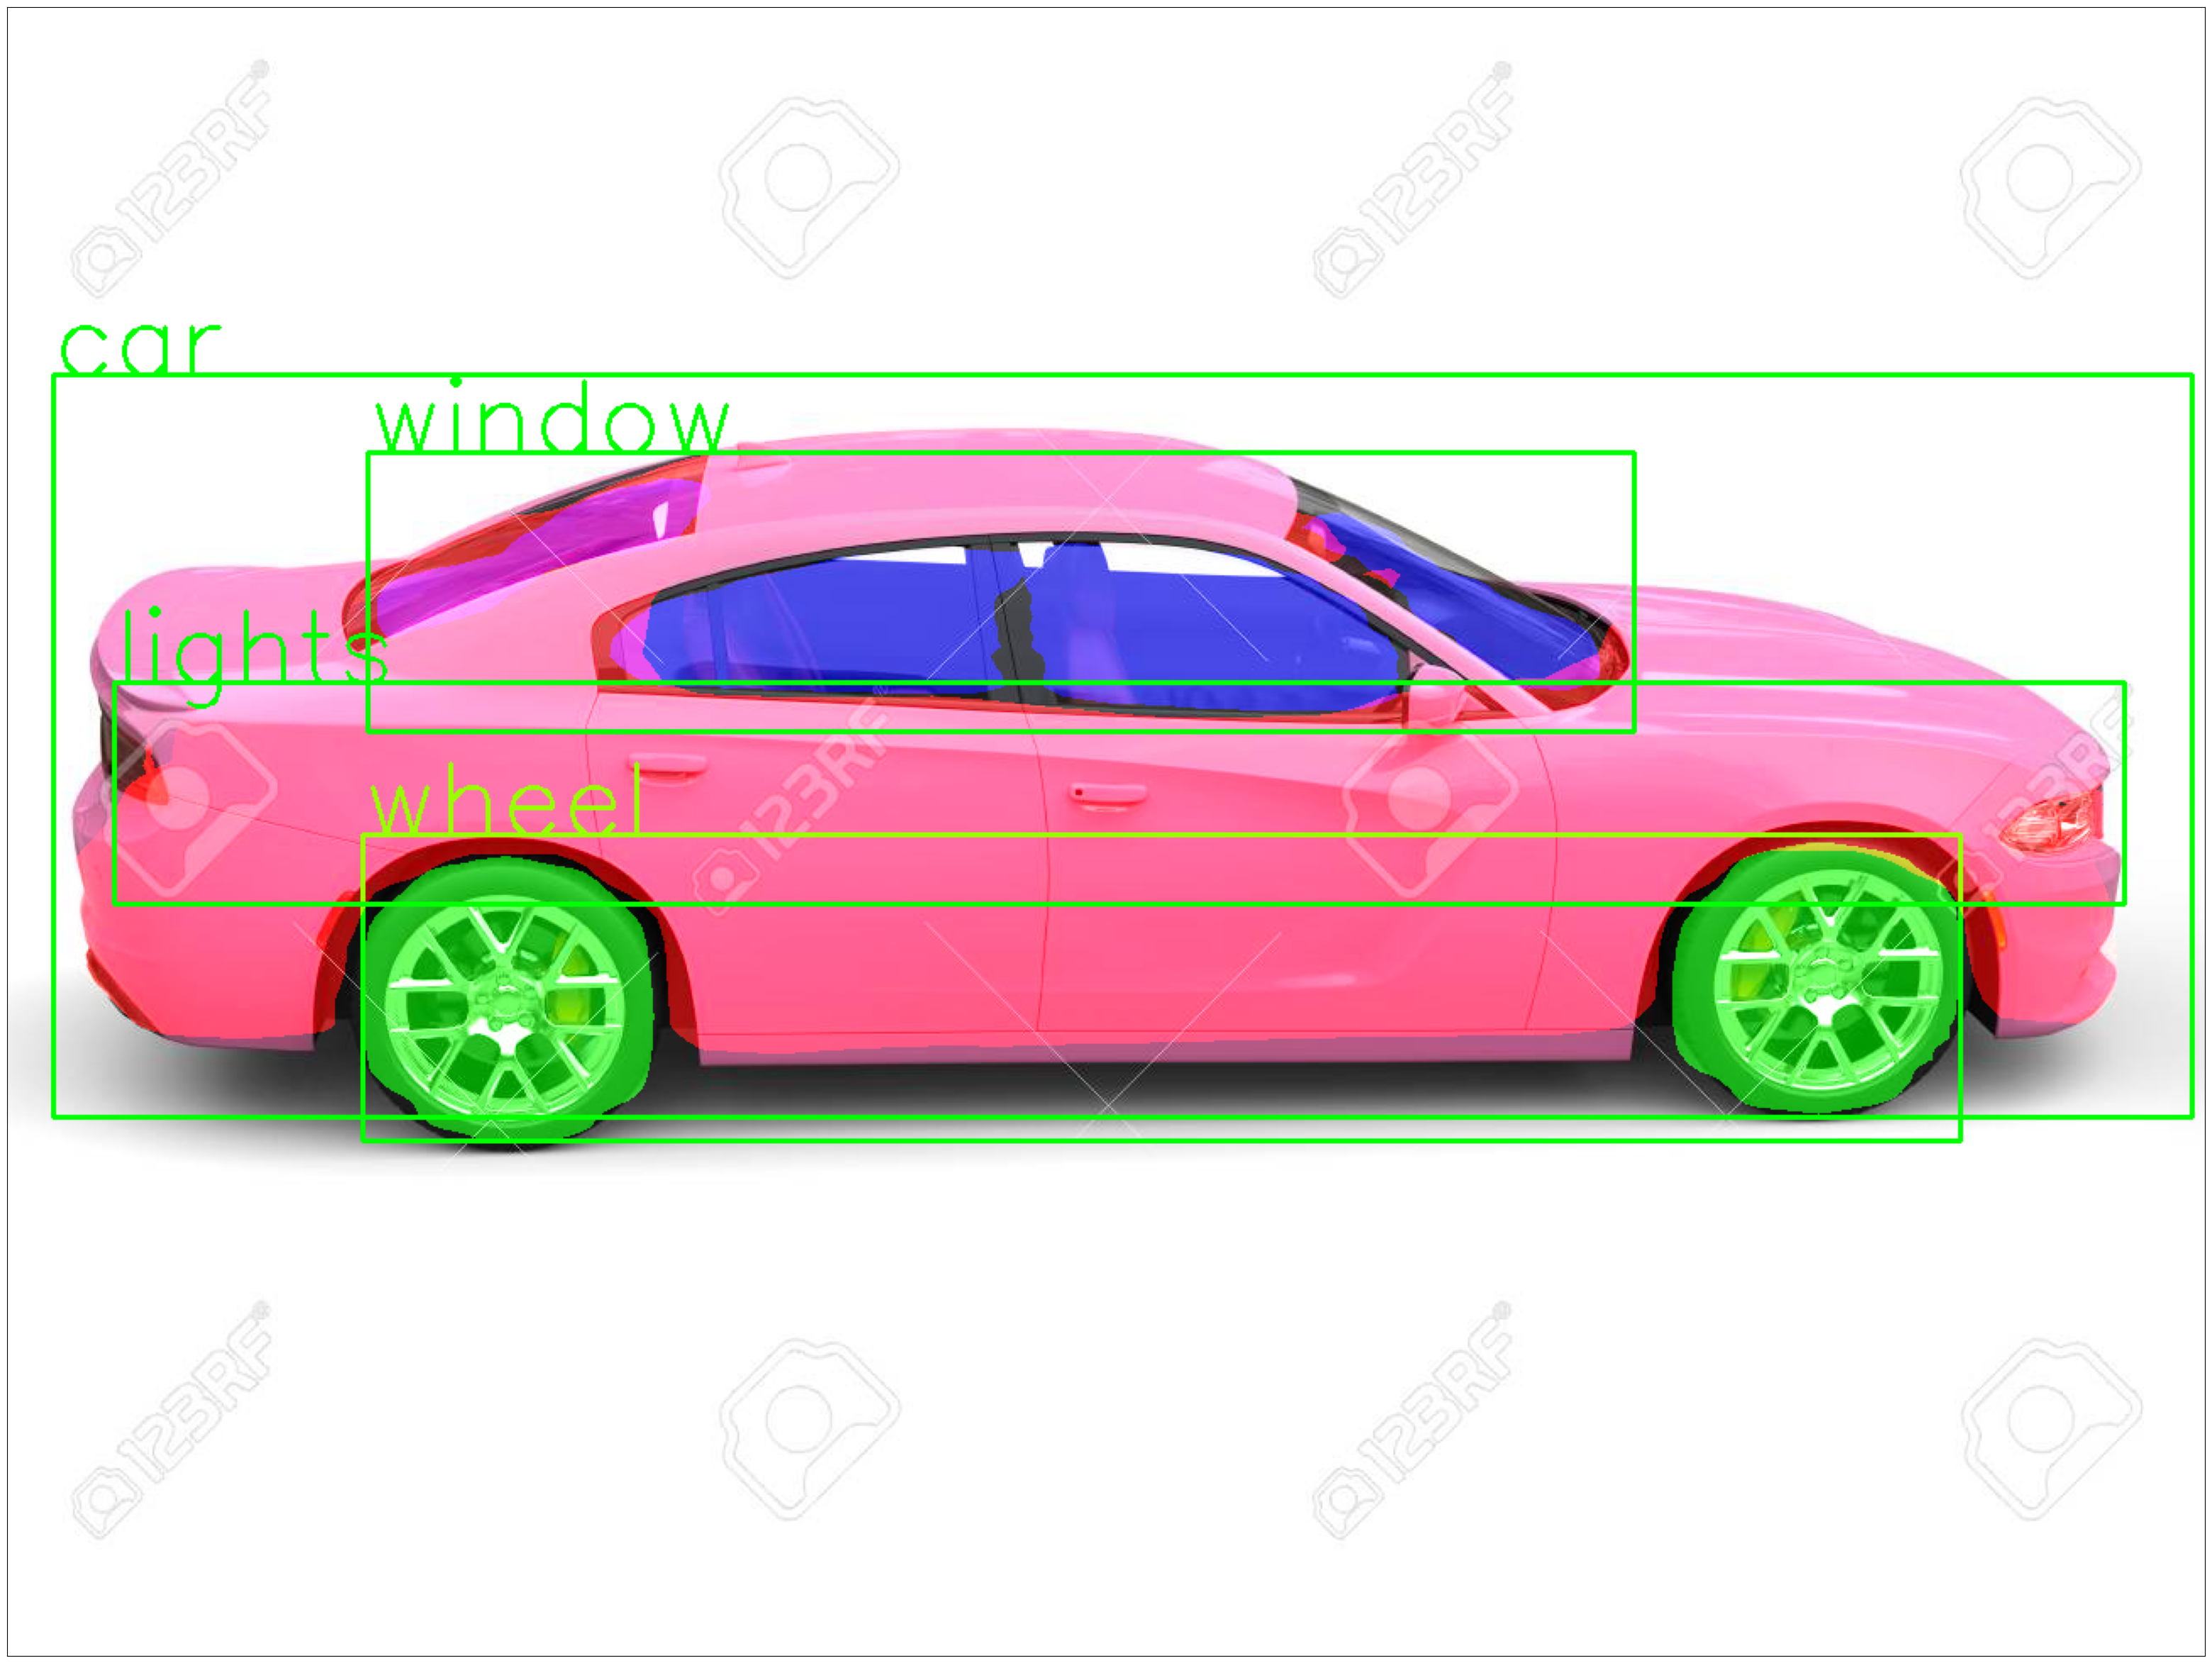

In [63]:
visualize_predictions('/kaggle/input/car-segmentation/car-segmentation/images/94374978-pretty-pink-modern-fast-city-car-side-view.png', confidence=0.7)